# Prediction analisys

first of all we need to define the target variable. The simplest way is to

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('dataset/incident_profile_95.csv')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 54 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CRASH_YEAR                            22516 non-null  int64  
 1   CRASH_MONTH                           22516 non-null  int64  
 2   BEAT_OF_OCCURRENCE                    22516 non-null  float64
 3   avg_responsibility_score              22516 non-null  float64
 4   avg_weather_severity                  22516 non-null  float64
 5   avg_roadway_severity                  22516 non-null  float64
 6   avg_lighting_severity                 22516 non-null  float64
 7   total_crashes                         22516 non-null  int64  
 8   fatality_rate                         22516 non-null  float64
 9   severe_injury_rate                    22516 non-null  float64
 10  avg_crash_severity_score              22516 non-null  float64
 11  injury_severity

In [47]:
# create a towed_runit_rate column,num_towed_units_LB w.r.t. monthly_total_units
df['towed_runit_rate'] = df['num_towed_units_LB'] / df['monthly_total_units']

In [48]:
categorical_columns = [col for col in df.columns if col.startswith("sum_")]
non_categorical_columns = df.columns.difference(categorical_columns)

In [49]:
df[non_categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BEAT_OF_OCCURRENCE              22516 non-null  float64
 1   CRASH_MONTH                     22516 non-null  int64  
 2   CRASH_YEAR                      22516 non-null  int64  
 3   adverse_weather_crash_rate      22516 non-null  float64
 4   avg_age                         22516 non-null  float64
 5   avg_crash_severity_score        22516 non-null  float64
 6   avg_lighting_severity           22516 non-null  float64
 7   avg_responsibility_score        22516 non-null  float64
 8   avg_roadway_severity            22516 non-null  float64
 9   avg_weather_severity            22516 non-null  float64
 10  combined_weather_road_severity  22516 non-null  float64
 11  damage_cost_LB                  22516 non-null  int64  
 12  damage_high                     

In [50]:
columns_to_drop = ['avg_weather_severity','avg_roadway_severity', 'damage_high', 'damage_low', 'damage_medium', 'neo_patented_drivers', 'total_drivers', 'total_units_department']
df = df.drop(columns=categorical_columns + columns_to_drop)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CRASH_YEAR                      22516 non-null  int64  
 1   CRASH_MONTH                     22516 non-null  int64  
 2   BEAT_OF_OCCURRENCE              22516 non-null  float64
 3   avg_responsibility_score        22516 non-null  float64
 4   avg_lighting_severity           22516 non-null  float64
 5   total_crashes                   22516 non-null  int64  
 6   fatality_rate                   22516 non-null  float64
 7   severe_injury_rate              22516 non-null  float64
 8   avg_crash_severity_score        22516 non-null  float64
 9   injury_severity_score           22516 non-null  float64
 10  night_crash_rate                22516 non-null  float64
 11  adverse_weather_crash_rate      22516 non-null  float64
 12  road_defect_crash_rate          

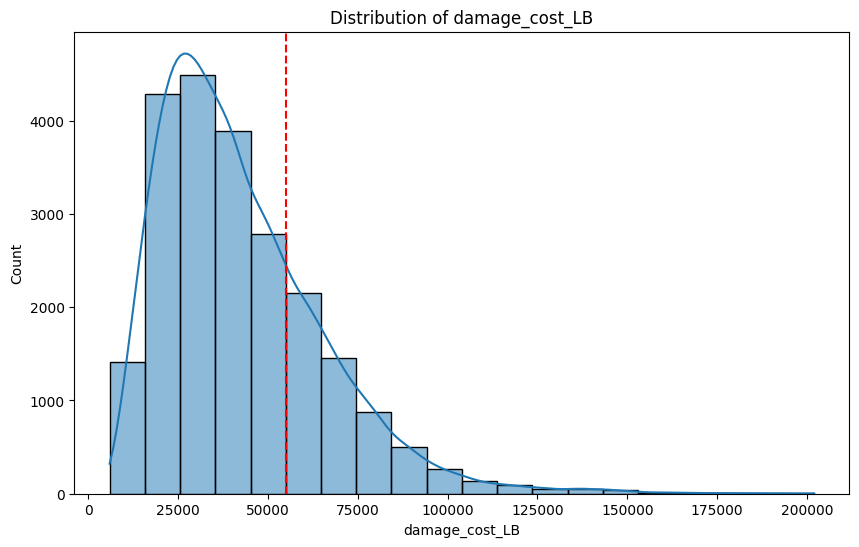

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(df['damage_cost_LB'], bins=20, kde=True)
plt.axvline(df['damage_cost_LB'].quantile(0.75), color='red', linestyle='--')
plt.title('Distribution of damage_cost_LB')
plt.show()

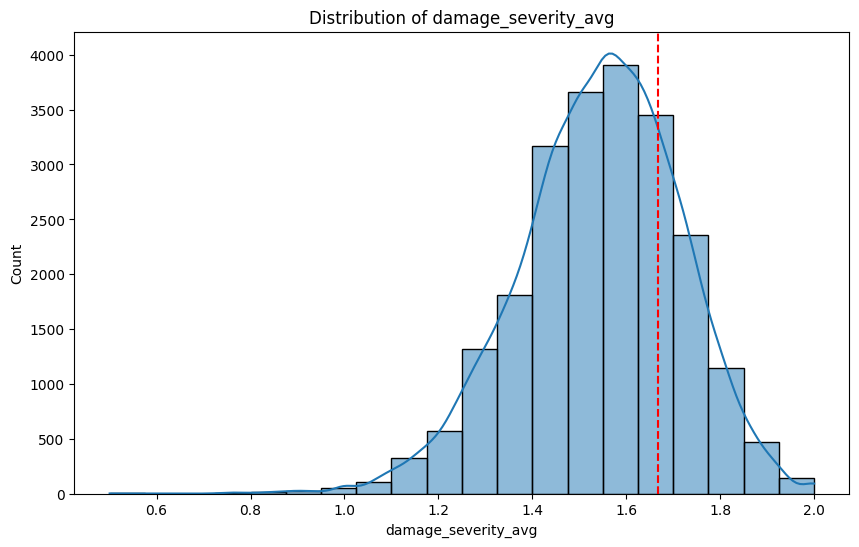

In [52]:
# distribution of damage_severity_avg
plt.figure(figsize=(10, 6))
sns.histplot(df['damage_severity_avg'], bins=20, kde=True)
plt.axvline(df['damage_severity_avg'].quantile(0.75), color='red', linestyle='--')
plt.title('Distribution of damage_severity_avg')
plt.show()


---

## Target variable definition
we will use the 75% quantile as the threshold for the damage_cost_LB, if the value is above this threshold we will consider it as a high damage and the Y value will be 1, otherwise 0


In [53]:
# first analisys using the damage_cost_LB column
df['DAMAGE_HIGH'] = df['damage_cost_LB'] > df['damage_cost_LB'].quantile(0.75)
df['DAMAGE_HIGH'] = df['DAMAGE_HIGH'].astype(int)



In [54]:
# DAMAGE columns
damage_columns = ['damage_cost_LB', 'damage_severity_avg']
df.drop(columns=damage_columns, inplace=True)
df.drop(columns=['BEAT_OF_OCCURRENCE'], inplace=True)

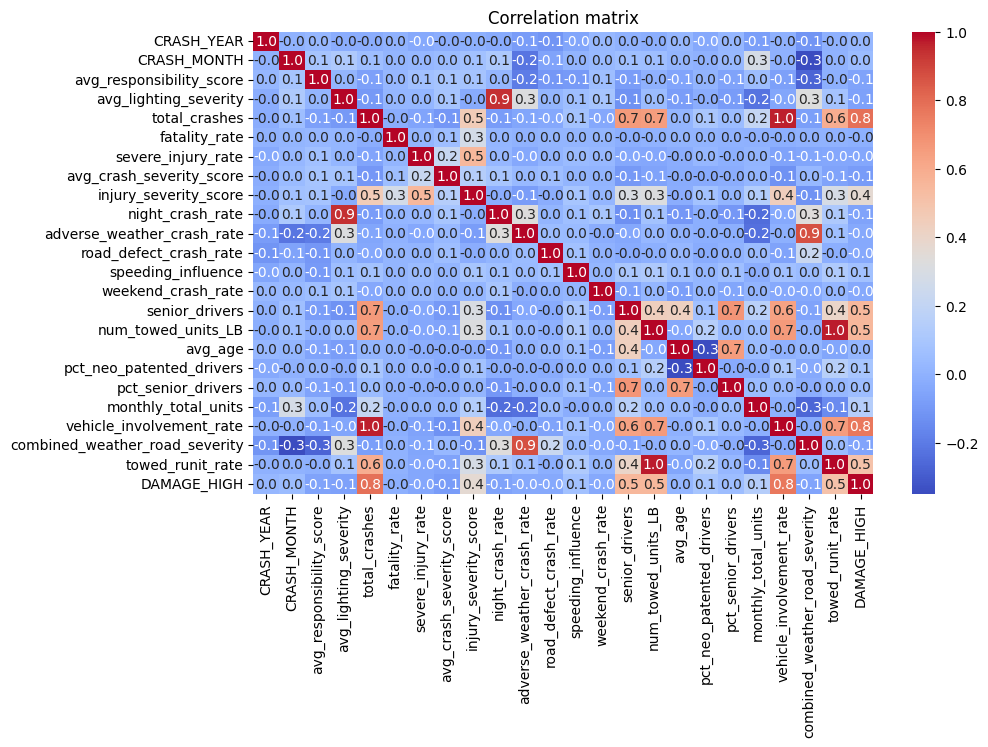

In [55]:
# correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation matrix')
plt.show()


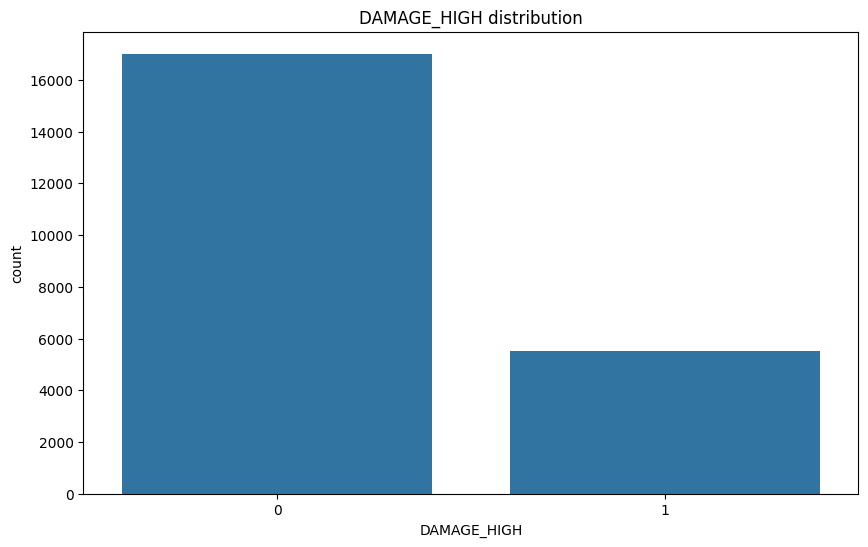

In [56]:
# plot DAMAGE_HIGH distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DAMAGE_HIGH')
plt.title('DAMAGE_HIGH distribution')
plt.show()


In [57]:
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

In [58]:
len(df_train), len(df_test)

(19289, 3227)

In [59]:
len(df_test) / len(df_train) * 100

16.729742340193894

## X and Y features

In [60]:
X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 23), (19289,), (3227, 23), (3227,))

---

# Models

The models that we will be using will be:
- Decision Trees
- Knn
- Naive Bayes
- Random Forests
- XGBoost
- Ada Boost
- Neural Network

## Random Forest

In [61]:
np.random.seed(42)
sklearn_random_seed = 42

In [62]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

hp_dt = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy'],
}

from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [63]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt.predict(X_test)))
confusion_matrix(y_test, grid_dt.predict(X_test))



Train accuracy: 0.97
Test accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2316
           1       0.97      0.95      0.96       911

    accuracy                           0.98      3227
   macro avg       0.97      0.97      0.97      3227
weighted avg       0.98      0.98      0.98      3227



array([[2285,   31],
       [  45,  866]])

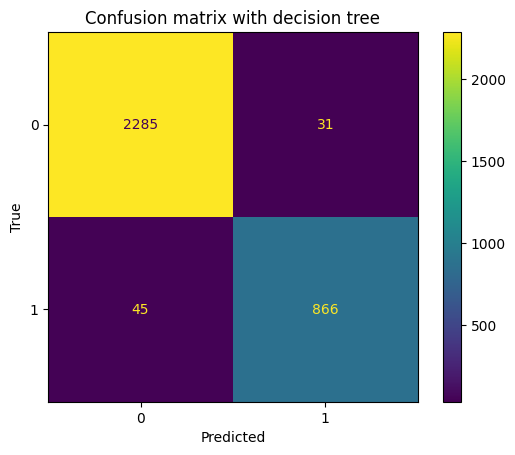

In [64]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns

cm = confusion_matrix(y_test, grid_dt.predict(X_test))
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')
plt.show()

---

## KNN

In [65]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


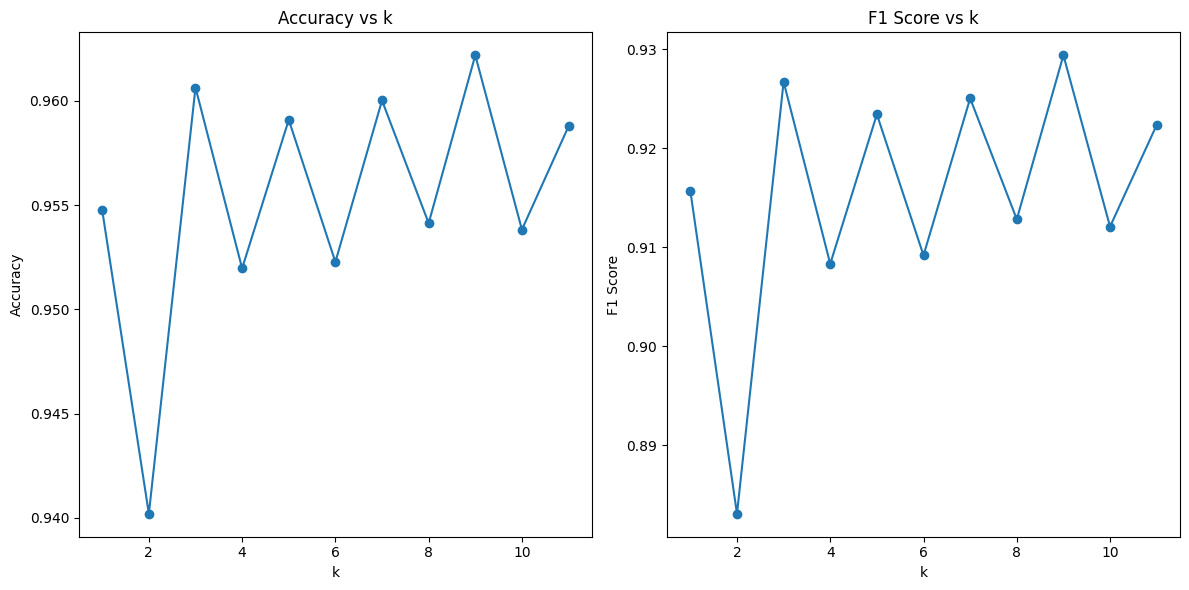

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# List of k values to try
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Lists to store the results
accuracies = []
f1_scores = []

for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', metric='minkowski')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Store the results
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')

plt.subplot(1, 2, 2)
plt.plot(k_values, f1_scores, marker='o')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score vs k')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2316
           1       0.98      0.88      0.93       911

    accuracy                           0.96      3227
   macro avg       0.97      0.94      0.95      3227
weighted avg       0.96      0.96      0.96      3227



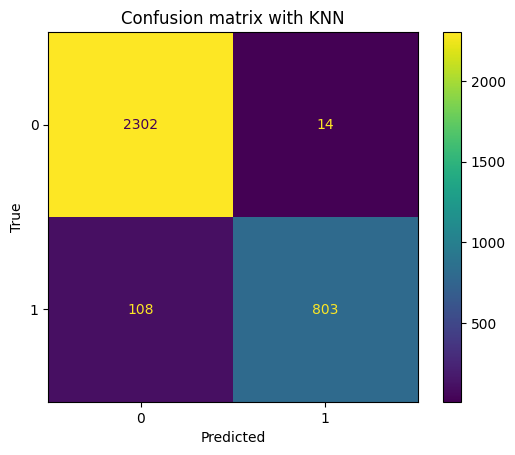

In [67]:
# confusion matrix with best k
knn = KNeighborsClassifier(n_neighbors=9, algorithm='ball_tree', metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with KNN')
plt.show()

---

## Random Forest

In [68]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

hp_rf = {
    'n_estimators': [8, 16, 32, 64],
    'max_depth': [3, 7, 11],
    'min_samples_split': [4, 8, 16],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy'],
}

rf = RandomForestClassifier(random_state=sklearn_random_seed)

grid_rf = GridSearchCV(estimator=rf, param_grid=hp_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

grid_rf.best_params_




Fitting 5 folds for each of 144 candidates, totalling 720 fits


{'criterion': 'entropy',
 'max_depth': 11,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 64}

In [69]:
print(f"Train accuracy: {grid_rf.best_score_:.2f}")
print(f"Test accuracy: {grid_rf.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_rf.predict(X_test)))
confusion_matrix(y_test, grid_rf.predict(X_test))

Train accuracy: 0.97
Test accuracy: 0.97
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2316
           1       0.98      0.91      0.94       911

    accuracy                           0.97      3227
   macro avg       0.97      0.95      0.96      3227
weighted avg       0.97      0.97      0.97      3227



array([[2296,   20],
       [  80,  831]])

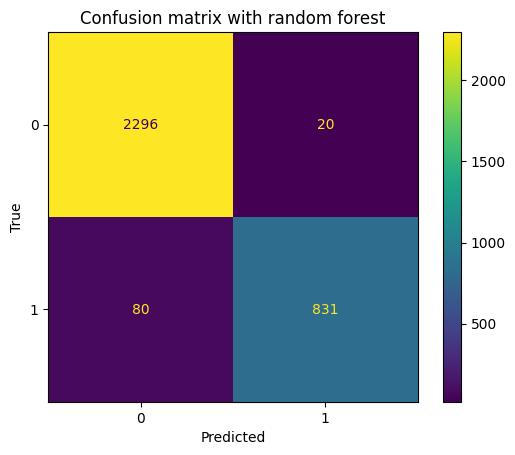

In [70]:
# confusion matrix
cm_rf = confusion_matrix(y_test, grid_rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_rf.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion matrix with random forest')
plt.show()

---

## feature analisys with SHAP

In [71]:
import shap

explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)

In [72]:
shap_values = explainer.shap_values(X_test)

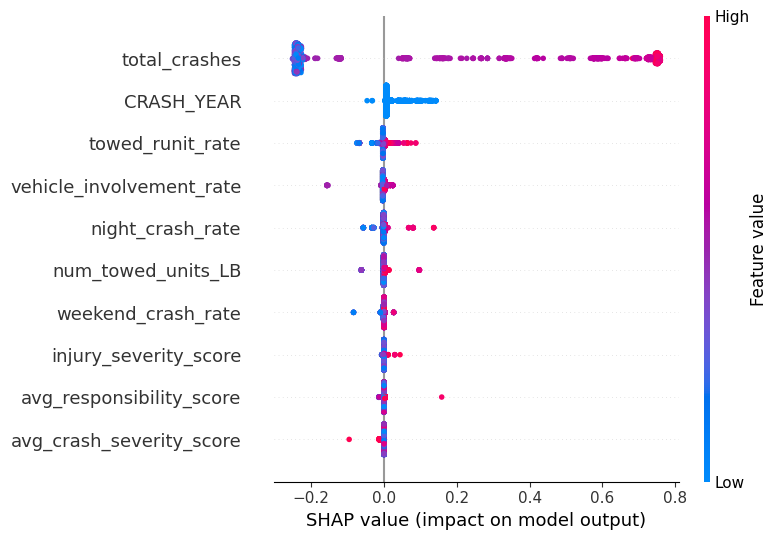

In [73]:
# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)

we can clearly see how the prediction is based mainly on the total_crashes column which we saw it was highly correlated to the damage feature.

In [74]:
df.columns

Index(['CRASH_YEAR', 'CRASH_MONTH', 'avg_responsibility_score',
       'avg_lighting_severity', 'total_crashes', 'fatality_rate',
       'severe_injury_rate', 'avg_crash_severity_score',
       'injury_severity_score', 'night_crash_rate',
       'adverse_weather_crash_rate', 'road_defect_crash_rate',
       'speeding_influence', 'weekend_crash_rate', 'senior_drivers',
       'num_towed_units_LB', 'avg_age', 'pct_neo_patented_drivers',
       'pct_senior_drivers', 'monthly_total_units', 'vehicle_involvement_rate',
       'combined_weather_road_severity', 'towed_runit_rate', 'DAMAGE_HIGH'],
      dtype='object')

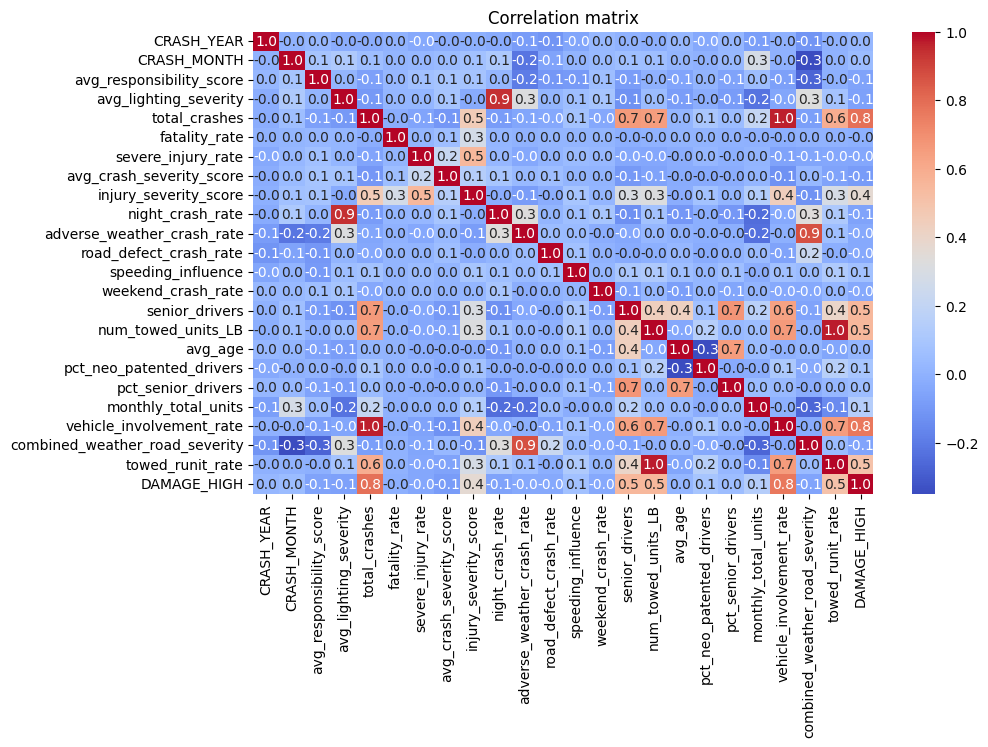

In [75]:
# correlation matrix
plt.figure(figsize=(10, 6))

sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation matrix')
plt.show()


In [76]:
columns_highly_correlated = ['total_crashes', 'vehicle_involvement_rate']
df.drop(columns=columns_highly_correlated, inplace=True)

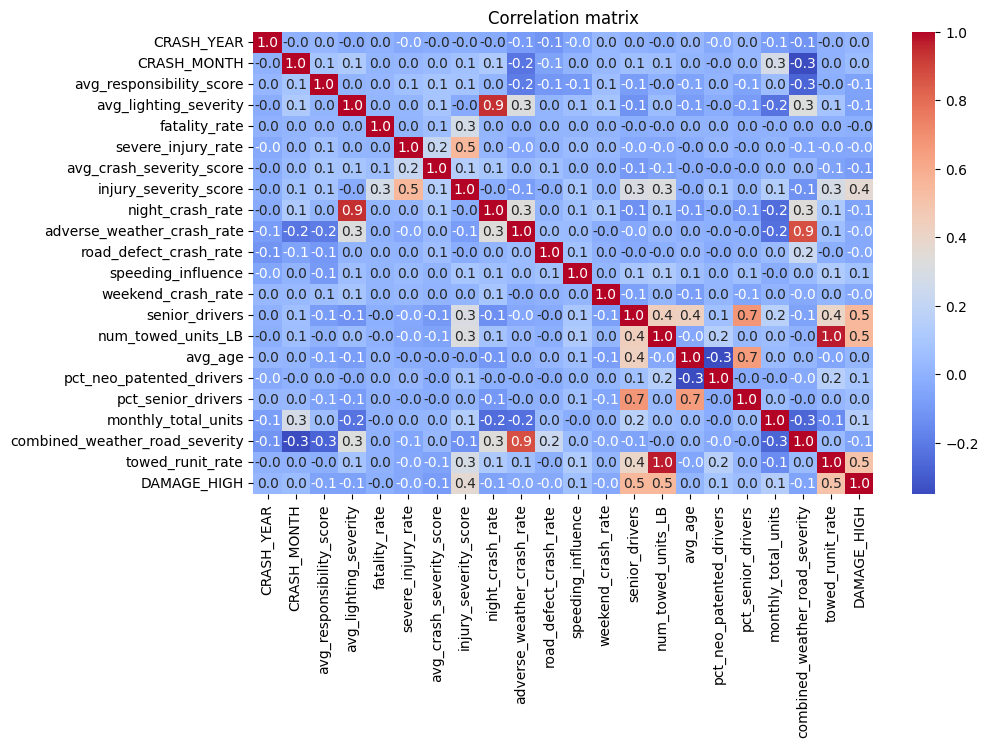

In [77]:
# correlation matrix
plt.figure(figsize=(10, 6))

sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation matrix')
plt.show()


In [78]:
# train test split
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 21), (19289,), (3227, 21), (3227,))

---

## Decision Tree without highly correlated features

In [79]:
# decision tree
dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [80]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")

print(classification_report(y_test, grid_dt.predict(X_test)))
confusion_matrix(y_test, grid_dt.predict(X_test))


Train accuracy: 0.95
Test accuracy: 0.94
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2316
           1       0.96      0.82      0.88       911

    accuracy                           0.94      3227
   macro avg       0.95      0.90      0.92      3227
weighted avg       0.94      0.94      0.94      3227



array([[2288,   28],
       [ 167,  744]])

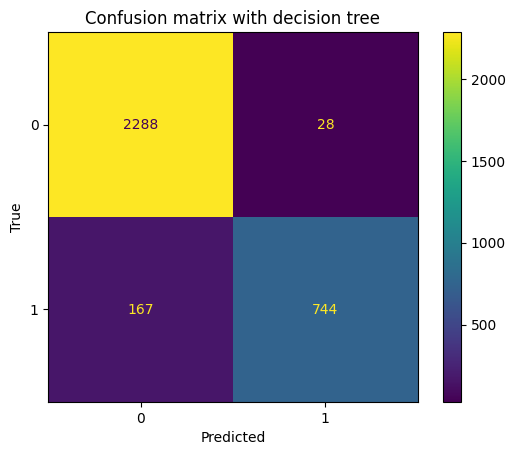

In [81]:
# confusion matrix
cm = confusion_matrix(y_test, grid_dt.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')

plt.show()


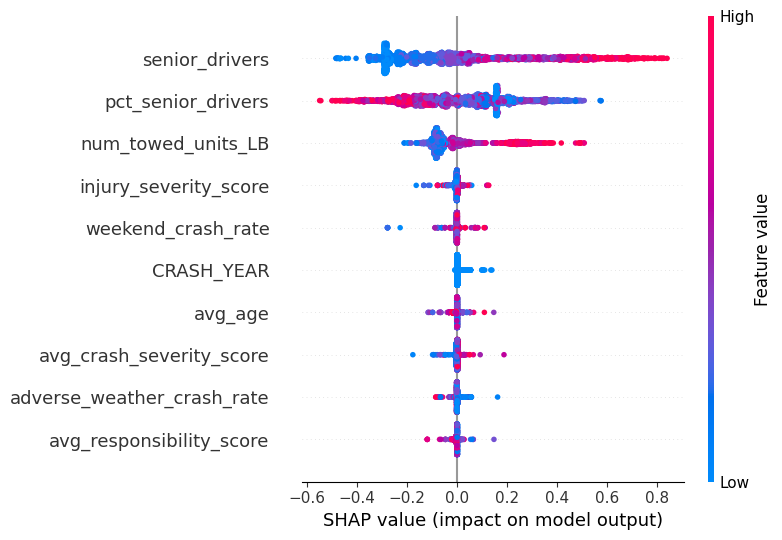

In [82]:
# shap values
explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)
